# Introduction
This notebook goes from (preprocessed) EEG data extraction to the fit of the HsMM-MVPA model in multiple conditions

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import itertools
import multiprocessing
import os
from mne.decoding import UnsupervisedSpatialFilter
import pyhsmm_mvpa as hsmm

cpus = multiprocessing.cpu_count()
print(cpus)

%load_ext autoreload
%autoreload 2


16


The following cells allow you to restrict the analysis to a subset of the participants. THis will ease the computational load on your machine but will be removed for the final analysis

# Loading EEG data
Then resample and create epochs (i.e. trial where time 0 is the time at which the stimulus appeared) and store in common xarray file (see https://docs.xarray.dev/en/stable/ for more info on that format)

In [2]:
event_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213, #conditions in the experiment
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223,
            'speed/left/1':111,'speed/left/2':112,'speed/left/3':113, #conditions in the experiment
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events

save_file = 'epoch_data_condition-wise.nc'
if save_file not in os.listdir():#avoids to loop again if notebook is restarted
    path = 'preprocessed_data/'
    subj_names = [x.split('_')[1].split('.')[0] for x in os.listdir(path) if 'preprocessed' in x]
    print(subj_names)
    subset =  subj_names #alternatively for testing purposes subset = ["S1","S2","S3"]
    epoch_data = hsmm.read_mne_EEG(path,subset,event_id,resp_id,1024)
    epoch_data.to_netcdf(save_file)
    epoch_data = xr.open_dataset(save_file)#For an unknown reason I need to re-read it
else:
    epoch_data = xr.open_dataset(save_file)

FileNotFoundError: [Errno 2] No such file or directory: 'preprocessed_data/'

In [ ]:
epoch_data

# Applying HsMM for the speed condition

In [4]:
speed, starts, ends = hsmm.transform_data(epoch_data.where(epoch_data.event.str.contains('speed'),drop=True),\
                           'participant',stack=True)

In [5]:
speed_init = hsmm.hsmm(speed.data.T, starts, ends, sf=epoch_data.sfreq)

In [6]:
if 'bests_speed.nc' not in os.listdir():
    max_estimates = speed_init.fit_single(speed_init.max_bumps())
    bump_loo_results = [max_estimates]
    i = 1
    for n_bumps in np.arange(speed_init.max_bumps()-1,0,-1):
        temp_best = bump_loo_results[-i]
        n_bumps_list = np.arange(n_bumps+1)
        possible_bumps = list(itertools.combinations(n_bumps_list, n_bumps))
        possible_flats = list(itertools.combinations(n_bumps_list+1, n_bumps))
        possible_flats = [np.insert(x,0,0) for x in possible_flats]
        with multiprocessing.Pool(processes=cpus) as pool:
            bump_loo_likelihood_temp = pool.starmap(speed_init.fit_single, 
                zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                    temp_best.parameters.values[possible_flats,:],
                    itertools.repeat(1),itertools.repeat(True)))
                    #repeat(np.tile([1,50], (n_bumps,1))),
                    #repeat(np.tile([2,12], (n_bumps,1)))))
        models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
        bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods ==models.likelihoods.max())[0][0]]))
        i+=1
    bests_speed = xr.concat(bump_loo_results, dim="n_bumps")
    bests_speed = bests_speed.assign_coords({"n_bumps": np.arange(speed_init.max_bumps(),0,-1)})
    bests_speed = bests_speed.squeeze('iteration')
    bests_speed.to_netcdf('bests_speed.nc')
else:
    bests_speed = xr.open_dataset("bests_speed.nc")
    print('recovering previous estimation')
bests_speed

recovering previous estimation


<xarray.Dataset>
Dimensions:      (n_bumps: 6, samples: 2074, trial: 7603, bump: 6, component: 10, stage: 7, params: 2)
Coordinates:
  * n_bumps      (n_bumps) int32 6 5 4 3 2 1
Dimensions without coordinates: samples, trial, bump, component, stage, params
Data variables:
    eventprobs   (n_bumps, samples, trial, bump) float64 ...
    magnitudes   (n_bumps, component, bump) float64 ...
    parameters   (n_bumps, stage, params) float64 ...
    likelihoods  (n_bumps) float64 ...

## Plotting the bump placement from this method

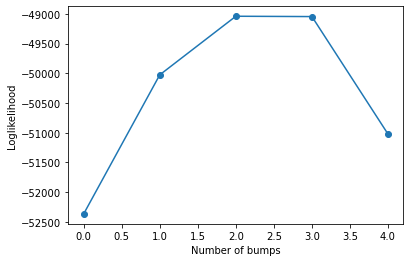

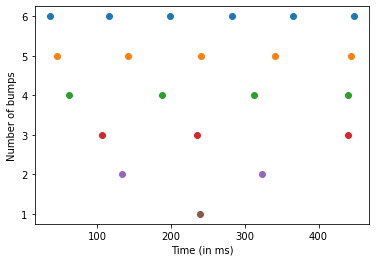

In [7]:
plt.plot(np.arange(speed_init.max_bumps()-1), bests_speed.likelihoods[1:],'o-')
plt.ylabel('Loglikelihood')
plt.xlabel('Number of bumps')
plt.show()
for nbump in np.arange(speed_init.max_bumps(),0,-1):
    times = speed_init.mean_bump_times(bests_speed.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
plt.xlabel('Time (in ms)')
plt.yticks(np.arange(speed_init.max_bumps())+1)
plt.ylabel('Number of bumps');

In [8]:
#Looping over possible number of bumps
subjects_idx = epoch_data.participant.values
likelihoods_loo = []

temp = speed.unstack().transpose('samples','epochs','component','participant')
bests = bests_speed
init = speed_init


all_n_bumps = []
for n_bumps in np.arange(1,speed_init.max_bumps()+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.LOOCV, 
            zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
    all_n_bumps.append(loo)

Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters 

In [9]:
all_n_bumps

[[(-2242.12529624194, 'S4'),
  (-3023.2294602325564, 'S16'),
  (-2485.089967674995, 'S2'),
  (-3979.7646789496557, 'S18'),
  (-4118.9062462768015, 'S3'),
  (-3206.7861470962994, 'S17'),
  (-3954.898162535488, 'S11'),
  (-3537.6093323802565, 'S1'),
  (-3334.0706743550436, 'S12'),
  (-3915.872527237064, 'S20'),
  (-3893.366220524225, 'S10'),
  (-3592.820606788526, 'S14'),
  (-3611.9080480221987, 'S15'),
  (-3686.623968375546, 'S13')],
 [(-2227.121379480537, 'S4'),
  (-3192.1952000316223, 'S16'),
  (-2283.496742616127, 'S2'),
  (-3435.5787125271772, 'S18'),
  (-3656.853965674409, 'S3'),
  (-2943.9560927120765, 'S17'),
  (-3592.0356234885257, 'S11'),
  (-2619.582367413329, 'S1'),
  (-2804.041406337469, 'S12'),
  (-3904.434945432772, 'S20'),
  (-3469.271447683699, 'S10'),
  (-3095.0039581756164, 'S14'),
  (-3314.6035560808623, 'S15'),
  (-3615.0791076461196, 'S13')],
 [(-2320.4556981546007, 'S4'),
  (-3233.3710105197383, 'S16'),
  (-2114.6566289456723, 'S2'),
  (-3417.4738674263117, 'S18'),

In [ ]:
plt.plot(np.arange(speed_init.max_bumps(),0,-1),np.mean(np.array(likelihoods_loo_speed),axis=0),'o-')
plt.ylabel('LOOCV Loglikelihood')
plt.xlabel('Number of bumps');

# Applying HsMM for the accuracy condition

In [ ]:
accuracy, starts, ends = hsmm.transform_data(epoch_data.where(epoch_data.event.str.contains('accuracy'),drop=True),\
                           'participant',stack=True)

In [ ]:
accuracy_init = hsmm.hsmm(accuracy.data.T, starts, ends, sf=epoch_data.sfreq)

In [ ]:
if 'bests_accuracy.nc' not in os.listdir():
    max_estimates = accuracy_init.fit_single(accuracy_init.max_bumps())
    bump_loo_results = [max_estimates]
    i = 1
    for n_bumps in np.arange(accuracy_init.max_bumps()-1,0,-1):
        temp_best = bump_loo_results[-i]
        n_bumps_list = np.arange(n_bumps+1)
        possible_bumps = list(itertools.combinations(n_bumps_list, n_bumps))
        possible_flats = list(itertools.combinations(n_bumps_list+1, n_bumps))
        possible_flats = [np.insert(x,0,0) for x in possible_flats]
        with multiprocessing.Pool(processes=cpus) as pool:
            bump_loo_likelihood_temp = pool.starmap(accuracy_init.fit_single, 
                zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                    temp_best.parameters.values[possible_flats,:],
                    itertools.repeat(1),itertools.repeat(True)))
                    #repeat(np.tile([1,50], (n_bumps,1))),
                    #repeat(np.tile([2,12], (n_bumps,1)))))
        models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
        bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods ==models.likelihoods.max())[0][0]]))
        i+=1
    bests_accuracy = xr.concat(bump_loo_results, dim="n_bumps")
    bests_accuracy = bests_accuracy.assign_coords({"n_bumps": np.arange(accuracy_init.max_bumps(),0,-1)})
    bests_accuracy = bests_accuracy.squeeze('iteration')
    bests_accuracy.to_netcdf('bests_accuracy.nc')
else:
    bests_accuracy = xr.open_dataset("bests_accuracy.nc")
    print('recovering previous estimation')
bests_accuracy

## Plotting the bump placement from this method

In [ ]:
plt.plot(np.arange(accuracy_init.max_bumps()-1), bests_accuracy.likelihoods[1:],'o-')
plt.ylabel('Loglikelihood')
plt.xlabel('Number of bumps')
plt.show()
for nbump in np.arange(accuracy_init.max_bumps(),0,-1):
    times = accuracy_init.mean_bump_times(bests_accuracy.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
plt.xlabel('Time (in ms)')
plt.yticks(np.arange(accuracy_init.max_bumps())+1)
plt.ylabel('Number of bumps');

In [ ]:
#Looping over possible number of bumps
subjects_idx = epoch_data.participant.values
likelihoods_loo = []

temp = accuracy.unstack().transpose('samples','epochs','component','participant')
bests = bests_accuracy
init = accuracy_init

for subject in subjects_idx:
    print(f'Subject {subject}')
    
    #Extracting data without left out subject
    stacked_loo = temp.sel(participant= subjects_idx[subjects_idx!=subject]).stack(all_samples=["participant",'epochs',"samples"]).dropna(dim="all_samples")
    
    durations_loo = np.unique(temp.sel(participant= subjects_idx[subjects_idx!=subject]).stack(trial=["participant",'epochs']).reset_index(["participant",'epochs']).groupby('trial').count(dim="samples").isel(electrodes=0).data.cumsum().to_numpy())
    starts_loo = np.insert(durations_loo[:-1],0,0)
    ends_loo = durations_loo-1
    
    #Fitting the HsMM using previous estimated parameters as initial parameters
    model_loo = hsmm.hsmm(stacked_loo.to_numpy().T, starts_loo, ends_loo, sf=epoch_data.sfreq)
    with multiprocessing.Pool(processes=cpus) as pool:
        iterative_results_loo = pool.starmap(model_loo.fit_single, 
            zip(np.arange(init.max_bumps(),0,-1),#init.max_bumps to ensure that same number of maxbumps
                bests.magnitudes, bests.parameters, itertools.repeat(1), itertools.repeat(False), itertools.repeat(True)))
    iterative_results_loo = xr.concat(iterative_results_loo, dim="n_bumps")
    
    #Evaluating likelihood for left out subject
    #Extracting data of left out subject
    stacked_left_out = z_scored.sel(participant= subject).stack(all_samples=['epochs',"samples"]).dropna(dim="all_samples")
    
    durations_left_out = np.unique(epoch_data.sel(participant= subject).stack(trial=['epochs']).reset_index(['epochs']).groupby('trial').count(dim="samples").isel(electrodes=0).data.cumsum().to_numpy())
    starts_left_out = np.insert(durations_left_out[:-1],0,0)
    ends_left_out = durations_left_out-1
    
    model_left_out = hsmm.hsmm(stacked_left_out.to_numpy().T, starts_left_out, ends_left_out, sf=epoch_data.sfreq)
    with multiprocessing.Pool(processes=cpus) as pool:
        likelihoods = pool.starmap(model_left_out.calc_EEG_50h, 
            zip(iterative_results_loo.magnitudes,
                iterative_results_loo.parameters,
                np.arange(init.max_bumps(),0,-1),itertools.repeat(True),itertools.repeat(True)))
    likelihoods_loo.append(likelihoods)
    np.save('likelihoods_loo_accuracy',likelihoods_loo)
likelihoods_loo_accuracy = likelihoods_loo

In [ ]:
plt.plot(np.arange(accuracy_init.max_bumps(),0,-1),np.mean(np.array(likelihoods_loo_accuracy),axis=0),'o-')
plt.ylabel('LOOCV Loglikelihood')
plt.xlabel('Number of bumps');

# Inspecting best model

In [ ]:
bump3_estimates_speed = bests_speed.sel(n_bumps=3)

In [ ]:
bump3_estimates_accuracy = bests_accuracy.sel(n_bumps=3)

In [ ]:
plt.plot(bump3_estimates_speed.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2,3]),'--')
plt.plot(bump3_estimates_accuracy.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2,3]))
plt.ylabel('p(event)')
plt.xlabel('Time (in samples)');

In [ ]:
times = accuracy_init.mean_bump_times(bump3_estimates_accuracy)
plt.plot(times, np.repeat(3, len(times)),'o')
times = speed_init.mean_bump_times(bump3_estimates_speed)
plt.plot(times, np.repeat(3, len(times)),'o')